In [1]:
import csv
from lxml import etree as et
from math import sin, cos, sqrt, atan2, radians
import networkx as nx
import osmnx as ox
from random import choices, random

In [2]:
def distance(node1,node2,nodes_data):
    R = 6373.0
    lon1 = radians(nodes_data[int(node1)]['x'])#lon
    lat1 = radians(nodes_data[int(node1)]['y'])#lat
    lon2 = radians(nodes_data[int(node2)]['x'])
    lat2 = radians(nodes_data[int(node2)]['y'])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

def nearest_node_id(node_a_id,nodes_info, pass_list = []):    
    min_dist = float('inf')
    if pass_list.count(node_a_id) == 0:
        pass_list.append(node_a_id)
    for node_b_id in nodes_info[0]:
        d = distance(node_a_id,node_b_id,nodes_info[1])
        if d < min_dist and node_b_id not in pass_list:
            min_dist = d
            nni = node_b_id
    return nni

In [3]:
def write_random_id(from_filename,to_filename_xml,to_filename_txt,size):
    data2, data3 = [],[]
    with open(from_filename,'r',newline='') as f:        
        data = f.readlines()        
        data = random.sample(data, size)
        for item in data:
            data2.append('  <id v=\"'+item[:-1]+'\"/>\n')
            data3.append(item)
        
    with open(to_filename_xml,'w',newline='') as f:       
        s = ''.join(data2)
        s = '<xml>'+s+'</xml>'
        f.write(s)

    with open(to_filename_txt,'w',newline='') as f:      
        s = ''.join(data3)
        f.write(s)


In [ ]:
# write_random_id('house_id.txt','100houses.xml','100houses.txt',100)
# write_random_id('med.txt','10med.xml','10med.txt',10)

In [4]:
def create_graph_from_osm(osm_file='graph.osm'):
    G_ox = ox.core.graph_from_file(osm_file,  simplify=False, retain_all=True)
    f = open('100houses.txt', 'r')
    houses_id = [house[:-1] for house in f.readlines()]
    f.close()
    f = open('10med.txt', 'r')
    med_id = [med[:-1] for med in f.readlines()]
    f.close()
    
    nodes_info = [[str(node) for node in G_ox.nodes], G_ox.nodes(data=True)]
    
    G = nx.DiGraph()
    context = et.iterparse(osm_file, events=('end',), tag='node')
    nodes = []
    for event, elem in context:
        #Пока не добавил все дома и вершины исключим только больницы
        if elem.get('id') not in houses_id and elem.get('id') not in med_id:
            nodes.append(elem.get('id'))
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
    del context
    G.add_nodes_from(nodes)
   
    context = et.iterparse(osm_file,events=('end',),tag='way')
    edges = []
    for event, elem in context:
        oneway = 0
        #Определим свойства
        for child in elem.iterchildren('tag'):
            key = child.get('k')      
            #Возможно, дорога односторонняя
            if key == 'oneway' and child.get('v') == 'yes':
                oneway = 1
        #Узнаем, какие вершины состоят в пути
        nodes_list = []
        for child in elem.iterchildren('nd'):
            _id = child.get('ref')
            nodes_list.append(_id)
        #Добавляем ребра с весами в список смежности
        if oneway == 1:
            for i in range(len(nodes_list)-1):
                #Добавляем вершины
                from_node, to_node = nodes_list[i:i+2]
                d = distance(from_node, to_node,nodes_info[1])
                edges.append((from_node, to_node, {'weight': d}))
        else:
            for i in range(len(nodes_list)-1):
                from_node, to_node = nodes_list[i:i+2]
                d = distance(from_node, to_node,nodes_info[1])
                edges.append((from_node, to_node, {'weight': d}))
                edges.append((to_node, from_node, {'weight': d}))
        elem.clear()
        while elem.getprevious() is not None:
            del elem.getparent()[0]
    del context

    G.add_edges_from(edges)

    
    #Добавим ребра к домам и больницам
    nearest_node_id_for_house,nearest_node_id_for_med = [],[]
    for h_id in houses_id:
        nni = nearest_node_id(h_id,nodes_info,houses_id+med_id)
        w = 1 + random()
        nearest_node_id_for_house.append(nni)
        for node in G.successors(nni):
            G[nni][node]['weight'] *= w
        for node in G.predecessors(nni):
            G[node][nni]['weight'] *= w
        
    copy_id = nodes_info[0]   
    for m_id in med_id:
        nni = nearest_node_id(m_id,nodes_info,houses_id+med_id)
        w = 1 + random()
        nearest_node_id_for_med.append(nni)
        for node in G.successors(nni):
            G[nni][node]['weight'] *= w
        for node in G.predecessors(nni):
            G[node][nni]['weight'] *= w

    houses_id = nearest_node_id_for_house.copy()
    med_id = nearest_node_id_for_med.copy()
    
    return G,houses_id,med_id


In [5]:
class MinNodeHeap:

    def __init__(self,g={}):
        self.heap = []
        self.size = 0
        self.g = g

    def left_index(self,i):
        return 2*i+1

    def right_index(self,i):
        return 2*i+2

    def parent_index(self,i):
        return (i-1)//2

    def min_heapify(self,i):
        l = self.left_index(i)
        r = self.right_index(i)

        if l < self.size and self.g[self.heap[l]]['weight'] < self.g[self.heap[i]]['weight']:
            smallest = l
        else:
            smallest = i
        if r < self.size and self.g[self.heap[r]]['weight'] < self.g[self.heap[smallest]]['weight']:
            smallest = r
        if smallest != i:
            self.g[self.heap[i]]['index'], self.g[self.heap[smallest]]['index'] = self.g[self.heap[smallest]]['index'], self.g[self.heap[i]]['index']           
            self.heap[i], self.heap[smallest] = self.heap[smallest], self.heap[i]
            self.min_heapify(smallest)

    def build_min_heap(self,_NodeView):
        self.heap = [None for i in range(len(_NodeView))]
        for elem in self.g:
            self.heap[self.g[elem]['index']] = elem
#         self.heap = list(_NodeView)
        self.size = len(_NodeView)
#         for i in range(len(_NodeView)//2,-1,-1):
#             self.min_heapify(i)
            
    def extract_min(self):
        if self.size < 1:
            return None
        _min = self.heap[0]
        self.g[self.heap[self.size-1]]['index'] = self.g[self.heap[0]]['index']
        self.heap[0] = self.heap[self.size-1]      
        self.size -= 1
        self.min_heapify(0)
        return _min
    
    def decrease_key(self,_id,key):
        i = self.g[_id]['index']
        if key > self.g[_id]['weight']:
            raise KeyError
        self.g[_id]['weight'] = key
        while (i > 0) and (self.g[self.heap[self.parent_index(i)]]['weight'] > self.g[self.heap[i]]['weight']):
            self.g[self.heap[self.parent_index(i)]]['index'], self.g[self.heap[i]]['index'] = self.g[self.heap[i]]['index'], self.g[self.heap[self.parent_index(i)]]['index']
            self.heap[self.parent_index(i)], self.heap[i] = self.heap[i], self.heap[self.parent_index(i)]
            i = self.parent_index(i)

            
def initialize_single_sourse(G,_from):
    g = {}
    nodes_list = list(G.nodes).copy()
    nodes_list.remove(_from)
    for v_id, i in zip(nodes_list,range(1,len(G.nodes))):
        g[v_id] = {'way': [], 'weight':float('inf'), 'index':i}
    g[_from] = {'way':[_from], 'weight':0, 'index':0}
    return g

def relax(G,min_heap,_from,_to):
    if min_heap.g[_to]['weight'] > min_heap.g[_from]['weight'] + G[_from][_to]['weight']:
        key = min_heap.g[_from]['weight'] + G[_from][_to]['weight']
        min_heap.decrease_key(_to,key)
        min_heap.g[_to]['way'] = (min_heap.g[_from]['way']).copy()
        min_heap.g[_to]['way'].append(_to)
        
def dijkstra(G,_from,to_list = 'empty'):
    if to_list == 'empty':
        to_list = list(G.nodes)
    g = initialize_single_sourse(G,_from)
    finish = 0
    nodes = MinNodeHeap(g)
    nodes.build_min_heap(G.nodes)
    while nodes.size > 0 and finish < len(to_list):
        u = nodes.extract_min()
        if to_list.count(u) > 0:
            finish += 1
        for v in G.successors(u):
            relax(G,nodes,u,v)
    return g


In [6]:
def create_adj_list(filename = 'adj_list2.csv'):
    with open(filename,'w',newline='') as csv_file:
        csv_file.write('from_id to_id,edge_weight\n')
        for _from in list(G.nodes):
            s = str(_from)
            for _to in G.successors(_from):
                s = s + ' ' + str(_to) + ',' + str(G[_from][_to]['weight'])
            csv_file.write(s + '\n')

In [7]:
def write_dijkstra_csv(G,filename,from_list,to_list):
    with open(filename,'w',newline='') as f:
        f.write('from,to,way_weight,way\n')
        for _from in from_list:
            a = dijkstra(G,_from,to_list)
            a = {k:v for k,v in a.items() if v["weight"] != float('inf')}
            for _to in to_list:
                if _to in a.keys():
                    s = _from + ',' + _to + ',' + str(a[_to]['weight'])
                    way = ','.join(a[_to]['way'])
                    s = s + ',' + way
                    f.write(s + '\n')

def read_dijkstra_csv(filename):
    min_ways = {}         
    with open(filename,'r') as f:
        lines = f.readlines()
        lines = lines[1:] 
        for line in lines:
            split_line = line[:-1].split(',')
            _from = split_line[0]
            _to = split_line[1]
            weight = float(split_line[2])
            if weight != float('inf'):
                way = split_line[3:]
            else: 
                way = []             
            if min_ways.get(_from) == None:
                min_ways[_from] = {_to:{'weight':weight,'way':way}}
            else:
                min_ways[_from][_to] = {'weight':weight,'way':way}
                
    return min_ways
            


In [8]:
def write_ways(filename,min_way):
    with open(filename,'w',newline='') as f:  
        f.write('from_id,to_id,way_weight\n')
        s = ''
        for _from in min_way.keys():
            s = s + _from + ',' + min_way[_from]['to'] + ',' + str(min_way[_from]['weight'])+'\n'
        f.write(s)


In [9]:
def search_min_oneways(min_ways,from_list,to_list):
    min_way = {}
    for _from in from_list:
        for _to in to_list:
            if _from != _to:
                if _from in min_ways.keys() and _to in min_ways[_from].keys():
                    if min_way.get(_from) == None:
                        min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'],'way':min_ways[_from][_to]['way']}
                    elif min_ways[_from][_to]['weight'] < min_way[_from]['weight']:
                        min_way[_from]['to'] = _to
                        min_way[_from]['weight'] = min_ways[_from][_to]['weight']                    
                        min_way[_from]['way'] =  min_ways[_from][_to]['way']
    return min_way


In [10]:
def search_min_ways_there_and_back(min_ways,from_list,to_list):
    min_way = {}
    for _from in from_list:
        for _to in to_list:
            if _from != _to:
                if _from in min_ways.keys() and _to in min_ways[_from].keys() and _to in min_ways.keys() and _from in min_ways[_to].keys():
                    if min_way.get(_from) == None:
                        min_way[_from] = {'to':_to,'weight':min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight'],'way':min_ways[_from][_to]['way'],'way_back':min_ways[_to][_from]['way']}
                    elif min_way[_from]['weight'] > min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']:
                        min_way[_from]['to'] = _to
                        min_way[_from]['weight'] = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                        min_way[_from]['way'] =  min_ways[_from][_to]['way']
                        min_way[_from]['way_back'] = min_ways[_to][_from]['way']
    return min_way


In [11]:
def search_near_ways(min_ways,max_weight,from_list,to_list):
    near_ways = []
    for _from in from_list:
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys():
                if min_ways[_from][_to]['weight'] <= max_weight and _from != _to:
                    near_ways.append([_from,_to,min_ways[_from][_to]['weight'],min_ways[_from][_to]['way']])
    return near_ways
                

In [12]:
def search_near_ways_there_and_back(min_ways,max_weight,from_list,to_list):
    near_ways = []
    for _from in from_list:
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys() and _to in min_ways.keys() and _from in min_ways[_to].keys():
                weight = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                if weight <= max_weight and _from != _to:
                    near_ways.append([_from, _to, weight, min_ways[_from][_to]['way'], min_ways[_to][_from]['way']])
    return near_ways


In [13]:
def search_minmax_way(min_ways,from_list,to_list):
    obj = 'start'
    minmax_way = {obj:{'weight':float('inf')}}
    for _from in from_list:
        weight = 0
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys():
                if min_ways[_from][_to]['weight'] > weight:
                    to = _to
                    weight = min_ways[_from][_to]['weight']
        if weight < minmax_way[obj]['weight']:
            minmax_way = {_from:{'to':to,'weight':weight}}
            obj = _from
    if obj != 'start':
        minmax_way[obj]['way'] = min_ways[obj][minmax_way[obj]['to']]['way'].copy()
    
    return minmax_way


In [14]:
def search_minmax_way_there_and_back(min_ways,from_list,to_list):
    obj = 'start'
    minmax_way = []
    for _from in from_list:
        weight = 0
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys() and _to in min_ways.keys() and _from in min_ways[_to].keys():
                w0 = min_ways[_from][_to]['weight'] + min_ways[_to][_from]['weight']
                if w0 != float('inf') and w0 > weight:
                    to = _to
                    weight = w0
                    if minmax_way == [] or weight < minmax_way[2]: 
                        obj = _from 
                        minmax_way = [obj,to,weight]
                        
    minmax_way.append(min_ways[obj][to]['way'])
    minmax_way.append(min_ways[to][obj]['way'])
    minmax_way = [minmax_way]
    
    return minmax_way


In [15]:
def search_min_distance_to_node(min_ways,from_list,to_list):
    #Для какого объекта инфраструктуры сумма кратчайших расстояний от него до всех домов минимальна
    min_sum = float('inf')
    ways = []
    for _from in from_list:
        _sum = 0
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys():
                _sum += min_ways[_from][_to]['weight']
        if _sum < min_sum:
            min_sum = _sum
            obj = _from
    for _to in to_list:
        if obj != _to and obj in min_ways.keys() and _to in min_ways[obj].keys():
            ways.append([obj,_to, min_ways[obj][_to]['weight'], min_ways[obj][_to]['way']])

    return obj,min_sum,ways


In [16]:
def search_min_weight_to_node(min_ways,from_list,to_list):
    #Для какого объекта инфраструктуры построенное дерево кратчайших путей имеет минимальный вес.
    min_sum = float('inf')
    ways = []
    for _from in from_list:
        _sum = 0
        edges_set = set()
        for _to in to_list:
            if _from in min_ways.keys() and _to in min_ways[_from].keys() and _to in min_ways.keys() and _from in min_ways[_to].keys():
                edges_set.add(_from + ' ' + _to)
        for elem in list(edges_set):
            i,j = elem.split(' ')
            _sum += min_ways[i][j]['weight']
        if _sum < min_sum:
            min_sum = _sum
            obj = _from
    for _to in to_list:
        if obj != _to and obj in min_ways.keys() and _to in min_ways[obj].keys():
            ways.append([obj,_to, min_ways[obj][_to]['weight'], min_ways[obj][_to]['way']])
    
    return obj,min_sum,ways


In [17]:
def draw_ways(_map,ways_orig):
    if type(ways_orig) == dict:
        ways = [way['way'] for way in ways_orig.values()]
        if 'way_back' in ways_orig[list(ways_orig.keys())[0]].keys():
            ways += [way['way_back'] for way in ways_orig.values()]
    elif type(ways_orig) == list:
        ways = [way[3] for way in ways_orig]
        if len(ways_orig[0]) == 5:
            ways += [way[4] for way in ways_orig]
    ways = list(map(lambda x: (list(map(int,x))),ways))

    ox.plot_graph_routes(_map, ways)
 

In [18]:
G,from_list,to_list = create_graph_from_osm()


In [19]:
# write_dijkstra_csv(G,'dijkstra1',from_list,to_list)
# write_dijkstra_csv(G,'dijkstra2',to_list,from_list)

In [36]:
min_ways = read_dijkstra_csv('dijkstra1')
min_ways.update(read_dijkstra_csv('dijkstra2'))
max_weight = 10#km
#Если нужно без записи
#res = []
#for _from in from_list:
#    res.append(dijkstra(G,_from,to_list))

#1a
min_oneways1 = search_min_oneways(min_ways,from_list,to_list)
min_oneways2 = search_min_oneways(min_ways,to_list,from_list)
min_ways_there_and_back = search_min_ways_there_and_back(min_ways,from_list,to_list)

#1b
near_ways1 = search_near_ways(min_ways,max_weight,from_list,to_list)
near_ways2 = search_near_ways(min_ways,max_weight,from_list,to_list)
near_ways_there_and_back = search_near_ways_there_and_back(min_ways,max_weight,from_list,to_list)

#2
minmax_way1 = search_minmax_way(min_ways,from_list,to_list)
minmax_way2 = search_minmax_way(min_ways,from_list,to_list)
minmax_way_there_and_back = search_minmax_way_there_and_back(min_ways,from_list,to_list)

#3
min_distance_to_node,min_distance,min_distance_way = search_min_distance_to_node(min_ways,from_list,to_list)
#4
min_weight_to_node,min_weight,min_weight_way = search_min_weight_to_node(min_ways,from_list,to_list)

In [29]:
_map = ox.core.graph_from_file('graph.osm',  simplify=False, retain_all=False)


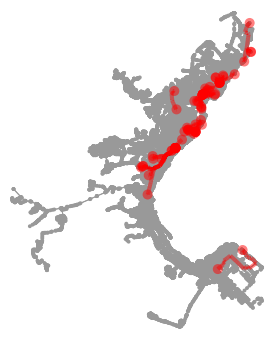

In [67]:
draw_ways(_map, min_oneways1)

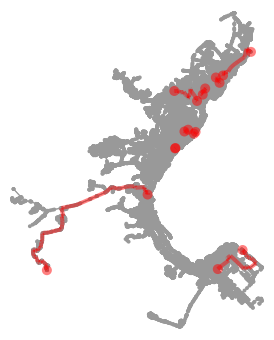

In [68]:
draw_ways(_map, min_oneways2)

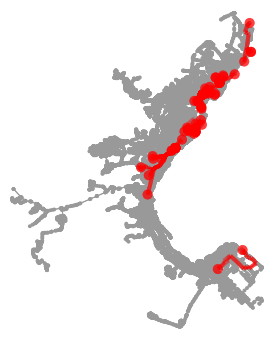

In [69]:
draw_ways(_map, min_ways_there_and_back)

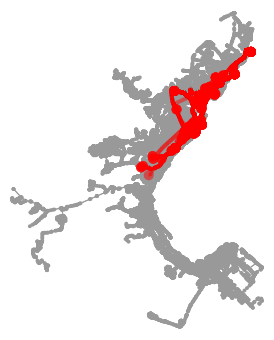

In [70]:
draw_ways(_map, near_ways1)

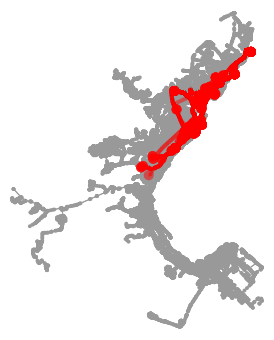

In [71]:
draw_ways(_map, near_ways2)

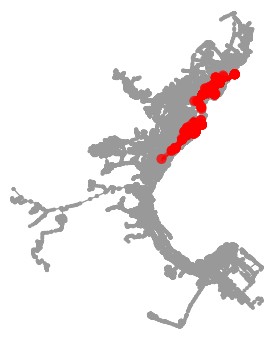

In [72]:
draw_ways(_map, near_ways_there_and_back)

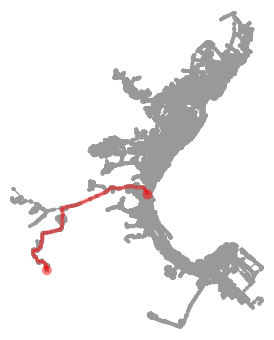

In [73]:
draw_ways(_map, minmax_way1)

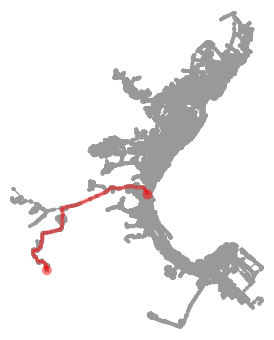

In [74]:
draw_ways(_map, minmax_way2)

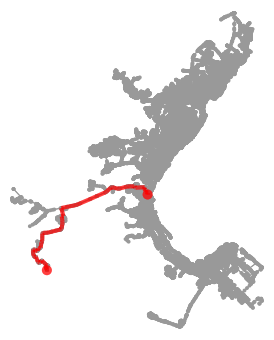

In [75]:
draw_ways(_map, minmax_way_there_and_back)

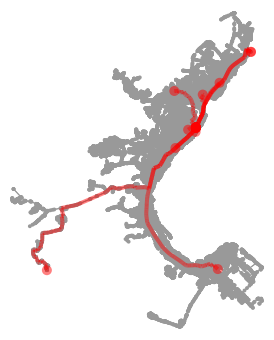

In [76]:
draw_ways(_map,min_distance_way)

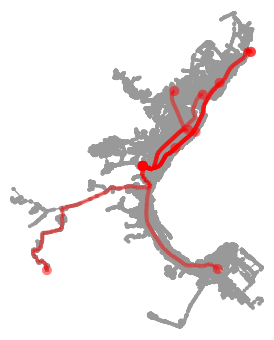

In [77]:
draw_ways(_map,min_weight_way)

In [ ]:
#Часть для Вовы

In [19]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

In [20]:
def get_tree_and_sum(G, _from, target_list):
    tree = dijkstra(G, _from, target_list)
    filtered_tree = {k:v for k,v in tree.items() if v["weight"] != float('inf') and k in target_list}
    tree_sum = sum(list(map(lambda x: x['weight'], list(filtered_tree.values()))))
    
    edge_set = list()
    for target in filtered_tree:
        node_list = filtered_tree[target]['way']
        for node_number in range(len(node_list)-1):           
            new_edge = [node_list[node_number], node_list[node_number + 1]]
            if new_edge not in edge_set:
                edge_set.append(new_edge)
    tree_small_sum = sum(list(map(lambda x: G[x[0]][x[1]]['weight'], edge_set)))
    return filtered_tree, tree_sum, tree_small_sum



In [22]:
G_d = ox.graph_from_place('Volgograd', network_type='drive', simplify = False)

In [23]:
nodes_info = [[str(node) for node in G_d.nodes], G_d.nodes(data=True)]

In [25]:
temp_tree, temp_tree_sum, temp_tree_small_sum = get_tree_and_sum(G, str(to_list[0]), nodes_info[0][20:50])

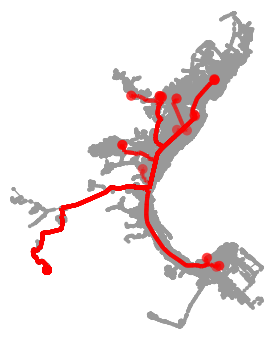

In [30]:
routes_temp = [temp_tree[key]['way'] for key in temp_tree]
routes_temp_2 = list(map(lambda x: [int(value) for value in x][3:-5], routes_temp))

fig, ax = ox.plot_graph_routes(_map, routes_temp_2)

In [ ]:
import collections
matrix = []
for house_id in houses_id:
    pre_vector = dijkstra(G, house_id, houses_id)
    filtered_vector = {k:v for k,v in pre_vector.items() if not math.isinf(v["weight"]) and k in houses_id}
    sorted_vector = collections.OrderedDict(sorted(filtered_vector.items()))
    vector = list(map(lambda x: x['weight'], list(sorted_vector.values())))
    matrix.append(vector)

In [ ]:
def cluster_to_id_list(cluster_index, cluster_cash, list_id, count_of_values):
    cluster_indexes = [cluster_index]
    while len(list(filter(lambda x: x > count_of_values, cluster_indexes))) > 0:
        cluster_to_open = list(filter(lambda x: x >= count_of_values, cluster_indexes))
        
        for cluster in cluster_to_open:
            cluster_indexes.remove(cluster)
            cluster_indexes.append(cluster_cash[int(cluster) - count_of_values, 0] )
            cluster_indexes.append(cluster_cash[int(cluster) - count_of_values, 1] )
            
    return list(map(lambda x: int(list_id[int(x)]), cluster_indexes))

In [ ]:
def get_centroid_coords(cluster_nodes):
    x = sum(list(map(lambda x: x['x'], cluster_nodes))) / len(cluster_nodes)
    y = sum(list(map(lambda x: x['y'], cluster_nodes))) / len(cluster_nodes)
    return y, x

In [ ]:
for i in range(99):
    if len(matrix[i]) != 100:
        matrix.remove(matrix[i])
        for j in len(matrix):
            matrix[j].remove(matrix[j][i])
print(len(matrix))

In [ ]:
import numpy as np
matrix_np = np.array(matrix)
cluster_cash = linkage(matrix_np, 'complete')
fig = plt.figure(figsize=(25, 20))
dn = dendrogram(cluster_cash)

In [ ]:
def get_cluster_info (cluster_index, cluster_cash, cluster_items_id, nodes_data):    
    cluster_nodes = cluster_to_id_list(cluster_index, cluster_cash, cluster_items_id, len(cluster_cash) + 1)
    str_cluster_nodes = list(map(lambda x: str(x),cluster_nodes))
    list_with_coords = list(map(lambda x: {'x': float(nodes_data[int(x)]['x']), 'y': float(nodes_data[int(x)]['y'])} ,cluster_nodes))
    centroid = get_centroid_coords(list_with_coords)
    centroid_id = ox.get_nearest_node(G_ox, centroid, method='euclidean')
    tree, tree_sum, tree_min_sum = get_tree_and_sum(G, str(centroid_id), str_cluster_nodes)
    return {'tree': tree, 'tree_sum':tree_sum, 'tree_min_sum':tree_min_sum, 'centroid_id':centroid_id, 'nodes': str_cluster_nodes}

In [ ]:
def open_next_cluster(cluster_cash, clusters, count_of_values):
    cluster_to_open = max(clusters)
    clusters.remove(cluster_to_open)
    clusters.append(cluster_cash[int(cluster_to_open) - count_of_values, 0] )
    clusters.append(cluster_cash[int(cluster_to_open) - count_of_values, 1] )
    return clusters

In [ ]:
clusters = [int(cluster_cash[-1,0]), int(cluster_cash[-1,1])]
cluters_info_2 = list(map(lambda x: get_cluster_info(x, cluster_cash, houses_id, nodes_data), clusters))

In [ ]:
clusters = open_next_cluster(cluster_cash, clusters, 100)
cluters_info_3 = list(map(lambda x: get_cluster_info(x, cluster_cash, houses_id, nodes_data), clusters))

In [ ]:
clusters = open_next_cluster(cluster_cash, clusters, 100)
clusters = open_next_cluster(cluster_cash, clusters, 100)

cluters_info_5 = list(map(lambda x: get_cluster_info(x, cluster_cash, houses_id, nodes_data), clusters))

In [ ]:
from functools import reduce

routes_clusters_str = reduce(lambda x,y: x + y, list(map(lambda x: [v['way'] for k,v in x['tree'].items()], cluters_info_2)))
routes_clusters = list(map(lambda x: list(map(lambda y: int(y), x)), routes_clusters_str))
routes_clisters_filtered = list(filter(lambda x: len(x) > 1, routes_clusters))

for cluster in cluters_info_3:
    print(len(cluster['tree']))

etokomfo = cluters_info_2[0]['tree'][str(tets_node)]['way'][3:-4]
for val in etokomfo:
    if val in houses_id:
        print(val)
